# Details - Gradient Attribution

This notebook complements the [docs](https://luminovo.gitlab.io/midnite/visualization.html) on how to use the different gradient attribution methods.

In general, gradient attribution methods propagate the gradient from the highest layer back to a lower layer, creating a heatmap of which neurons where most influential.

In [1]:
%%capture
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

## Preparation: Load Pretrained Model and Example Data

As in other notebooks, we use a pretrained alexnet. We also extract the list of layers from the network, using the `Flatten` layer for the `torch.Tensor.view` that is called in the alexnet `forward` method.

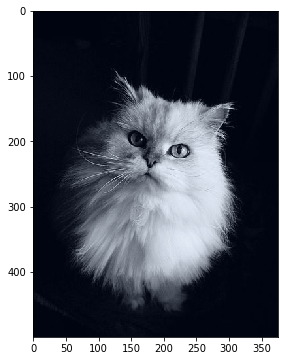

In [2]:
from torchvision import models
import data_utils
import midnite
from midnite.common import Flatten
from plot_utils import show_heatmap, show_normalized

alexnet = models.alexnet(pretrained=True)
alexnet.eval()

alexnet_layers = [
    *alexnet.features.children(),
    alexnet.avgpool,
    Flatten(),
    *alexnet.classifier.children()
]

example_img = data_utils.get_example_from_path(
    "../data/imagenet_example_283.jpg",
    data_utils.DataConfig.ALEX_NET
)

show_normalized(example_img)

## (Guided) Backpropagation

Simply backpropagating the gradient usually is not useful on its own - here, we split the input layer spatially to obtain a heatmap for the original image w.r.t. the output neuron for the target class.

Even overlayed with the original image, we can not pick p any useful information:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


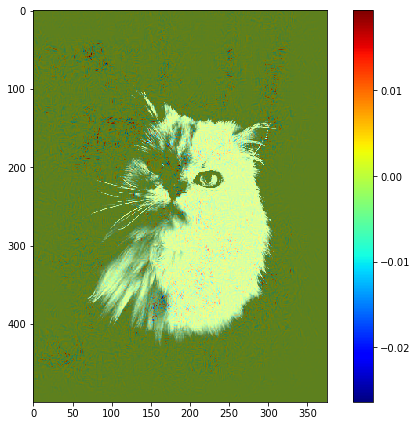

In [3]:
from plot_utils import show_heatmap
from midnite.visualization.base import *

show_heatmap(Backpropagation(
    alexnet,
    SplitSelector(NeuronSplit(), [283]),
    SpatialSplit(),
).visualize(example_img), scale=1.2, img=example_img)

Guided backpropagation works much better for CNNs with ReLU activations:

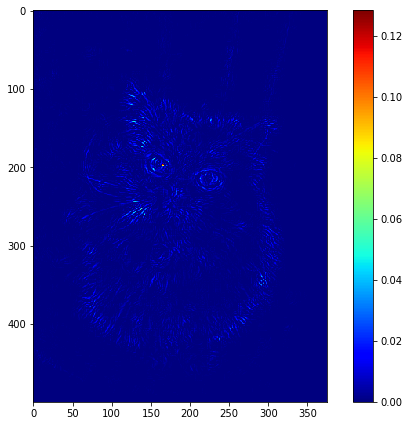

In [4]:
show_heatmap(GuidedBackpropagation(
    alexnet_layers,
    SplitSelector(NeuronSplit(), [283]),
    SpatialSplit(),
).visualize(example_img), scale=1.2)

## Gradient Attribution Mapping

Gradient attribution mapping methods are more complicated, and thus require some explanation.

### Classic Usecase

Most of the time - as in previous examples - we are interested in the attribution to some output class (or classes), which we specify with the `top_layer_selector`. We also specify some split of the input layer (`bottom_layer_split`), but here comes the tricky part:

For gradient attribution mappings, we first have some _base_ feature layers through which the input is passed - allowing us to analyze which _parts_ of the image were interesting to the network - and then the _inspection layers_ (consisting of feature and classification layers), where we calculate _how much_ those parts contributed to the output.
<img src="resources/class-activation-mapping.png">

If we only use the first few layers as base, we get a heatmap of the low-level features that are important for prediction (and vice versa):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


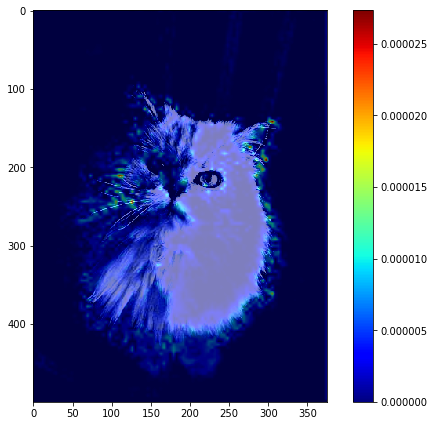

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


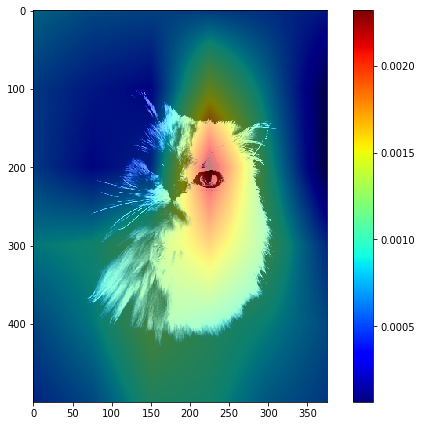

In [5]:
from torch.nn import Sequential
from plot_utils import show_heatmap

for network_split in [2, 14]:
    show_heatmap(GradAM(
        Sequential(*alexnet_layers[network_split:]), 
        SplitSelector(NeuronSplit(), [283]),
        Sequential(*alexnet_layers[:network_split]), 
        SpatialSplit(),
    ).visualize(example_img), 1.2, example_img)

**Note**: for alexnet, layers 0-14 are all feature layers, so the last image is exactly a class activation mapping.

### General Case

In general, with the `inspection_layers` variable, we can also control how deep we want to descend into the network:
<img src="resources/saliencies_gradCAM.png">

## A Word to Guided GradCAM
Guided GradCAM is a quite popular technique. However, there is no building block for it, since it merely a combination of two instances of building blocks we already have: A guided backpropagation for a spatial split w.r.t. the top-3 output classes, weighted by a gradient attribution mapping, using feature layers as base and the classifier as inspeciton net (for the same output selection).

Hence, Guided GradCAM is implemeted in midnite as a compound method.